In [2]:
import numpy as np
import uproot as ur
import awkward as ak
import sys
sys.path.append('/home/mjovanovic/Work/LCStudies')
from data import particle_data_visualize_plot_utils as pu
import matplotlib.pyplot as plt


Helper functions

In [3]:
def flatten_event_to_cells(event):
    return np.array([cell for clus in event for cell in clus])

def flatten_events_and_clus_to_events(events_data):
    return [[cell_data for clus_data in event_data for cell_data in clus_data] for event_data in events_data]

def flatten_events_to_clus(events_data):
    return [clus_data for event_data in events_data for clus_data in event_data]

def flatten_one_layer(data):
    return [data_layer2 for data_layer1 in data for data_layer2 in data_layer1]

def flatten_layers(data, num_layers=1):
    for i in range(num_layers):
        data = flatten_one_layer(data)
    return data

def flatten_events_to_cells(events_data):
    return [cell_data for clus_data in flatten_events_to_clus(events_data) for cell_data in clus_data]

def DeltaR(etas1, phis1, etas2, phis2):
    return np.sqrt((etas1-etas2)**2 + (phis1-phis2)**2)

Load rho event tree

In [4]:
rho_root_data = ur.open("/data/mjovanovic/train_testing_data/mltree_1000_compare.root")
rho_root_data_summed_truth_E = ur.open("/data/mjovanovic/train_testing_data/mltree_1000_compare_summed_truth_E.root")

events = rho_root_data["EventTree"]
events_arr = events.arrays(library="ak")
events_arr_np = events.arrays(library="np")

events_summed_truth_E = rho_root_data_summed_truth_E["EventTree"]
events_arr_summed_truth_E = events_summed_truth_E.arrays(library="ak")

In [376]:
# cut out the negative enrgy depoists
events_arr["cluster_cell_hitsTruthE"] = events_arr["cluster_cell_hitsTruthE"][events_arr["cluster_cell_hitsTruthE"] >= 0]
events_arr["cluster_cell_hitsTruthIndex"] = events_arr["cluster_cell_hitsTruthIndex"][events_arr["cluster_cell_hitsTruthE"] >= 0]

# cut out the events w a electron/positron
# [ 213.  211.  111.  -11.   11.   22.]
# find the occurances of this array in the list 
events_arr_resized = {}
elec_pos_events = ak.Array([len(event_truthPartPdgId) == 6 and np.count_nonzero(event_truthPartPdgId == [ 213.,  211.,  111.,  -11.,   11.,   22.]) == 6 for event_truthPartPdgId in events_arr_np["truthPartPdgId"]])

for key in events.items():
    events_arr_resized[key[0]] = events_arr[key[0]][~elec_pos_events]

events_arr = events_arr_resized

Truth contributions analysis

In [380]:
# find unique sets of truth particles
pgIds_pad = []
for event_idx, event_pgIds in enumerate(events_arr["truthPartPdgId"]):
    pgIds_pad.append(np.zeros(8))
    pgIds_pad[event_idx][:len(event_pgIds)] = event_pgIds

unique_truth_particles, num_occurances = np.unique(pgIds_pad, return_counts=True, axis=0)
print(unique_truth_particles)
print(num_occurances)


[[-213. -211.  111.   22.   22.    0.    0.    0.]
 [-213. -211.  111.   22.   22.   22.    0.    0.]
 [-213. -211.  111.   22.   22.   22.   22.    0.]
 [ 213.  211.  111.   22.   22.    0.    0.    0.]
 [ 213.  211.  111.   22.   22.   22.    0.    0.]
 [ 213.  211.  111.   22.   22.   22.   22.    0.]]
[213  32   1 225  26   1]


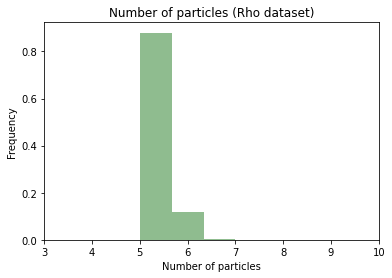

events with one 2 gamma: 87.95180722891565%
events with one 3 gamma: 11.646586345381527%
events with one 4 gamma: 0.4016064257028112%


In [378]:
# find distribution of number of truth particles in event
num_particles = np.array([len(particle_ids) for particle_ids in events_arr["truthPartPdgId"]])
pu.plot_hist(num_particles, 3, "Number of particles (Rho dataset)", "Number of particles", "Frequency", colour="darkseagreen", xlim=(3,10))

print("events with one 2 gamma:", str(len(num_particles[num_particles == 5])/len(num_particles)*100) + "%")
print("events with one 3 gamma:", str(len(num_particles[num_particles == 6])/len(num_particles)*100) +"%")
print("events with one 4 gamma:", str(len(num_particles[num_particles == 7])/len(num_particles)*100) +"%")


/tmp/ipykernel_27678/1213608867.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  num_truth_contributions = np.array([[len(cell_truth_con) for clus_truth_con in event_truth_con for cell_truth_con in clus_truth_con]  for event_truth_con in events_arr["cluster_cell_hitsTruthIndex"]])


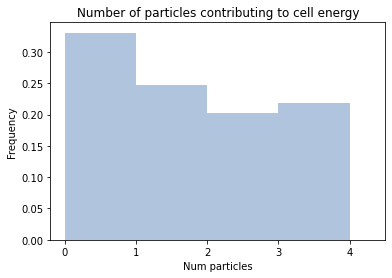

In [381]:
# number of particles contributing to each cell
num_truth_contributions = np.array([[len(cell_truth_con) for clus_truth_con in event_truth_con for cell_truth_con in clus_truth_con]  for event_truth_con in events_arr["cluster_cell_hitsTruthIndex"]])
pu.plot_hist(flatten_one_layer(num_truth_contributions), 4, "Number of particles contributing to cell energy", "Num particles", "Frequency", xlim=(None, 4.5), colour="lightsteelblue", discrete=True)

5


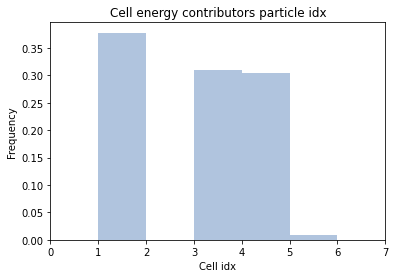

37.795% of energy contributions are from the charged pion and 62.205% are from the 2 gammas


In [339]:
# Of these particles which are depositing energy into the cells
# idx: 0-rho, 1-pi+/-, 2-pi0, 3-gamma, 4-gamma, 5-gamma
truth_part_name = { 0: "rho+/-", 1: "pi+/-", 2: "pi0", 3: "gamma1", 4: "gamma2", 5: "gamma3", 6: "gamma4" }
cell_energy_contr_part_idx = np.array(flatten_layers(events_arr["cluster_cell_hitsTruthIndex"], 3))
print(np.max(cell_energy_contr_part_idx))
pu.plot_hist(cell_energy_contr_part_idx, 5, "Cell energy contributors particle idx", "Cell idx", "Frequency", colour="lightsteelblue", xlim=(0,7), discrete=True) 
print(str(round((len(cell_energy_contr_part_idx[cell_energy_contr_part_idx == 1])/len(cell_energy_contr_part_idx))*100, 3)) + "% of energy contributions are from the charged pion and " + str(round((len(cell_energy_contr_part_idx[cell_energy_contr_part_idx != 1])/len(cell_energy_contr_part_idx))*100, 3)) + "% are from the 2 gammas")


118738


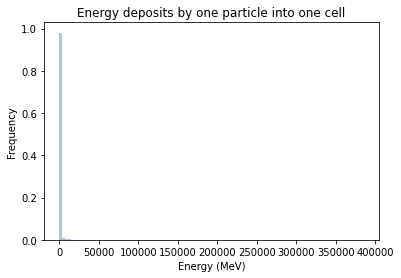

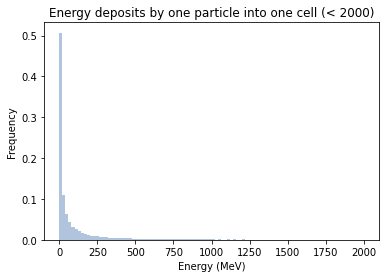

range: 0.0 -> 385487.5
energy deposits < 0: 0.0%
energy deposits < 2000: 96.571%
events with a neg energy deposit: 0.0%


In [382]:
# how much energy are these single particles depositing into the cells
part_energy_deposits = np.array(flatten_layers(events_arr["cluster_cell_hitsTruthE"], 3))
print(len(part_energy_deposits))
pu.plot_hist(part_energy_deposits, 100, "Energy deposits by one particle into one cell", "Energy (MeV)", "Frequency", colour="lightsteelblue")
pu.plot_hist(part_energy_deposits[part_energy_deposits < 2000], 100, "Energy deposits by one particle into one cell (< 2000)", "Energy (MeV)", "Frequency", colour="lightsteelblue")
#pu.plot_hist(part_energy_deposits[part_energy_deposits < 0], 100, "Energy deposited by one particle into one cell (< 0)", "Energy (MeV)", "Frequency", colour="lightsteelblue")
print("range:", round(np.min(part_energy_deposits), 4), "->", np.max(part_energy_deposits))
print("energy deposits < 0:", str(round(len(part_energy_deposits[part_energy_deposits < 0])/len(part_energy_deposits), 5)*100) + "%")
print("energy deposits < 2000:", str(round(len(part_energy_deposits[part_energy_deposits < 2000])/len(part_energy_deposits), 5)*100) + "%")

# percent of events with a neg cell deposit
part_energy_deposits_events = np.array([np.count_nonzero([cell_part_deposit < 0 for cell_part_deposit in flatten_layers(event_part_deposits, 2)]) > 0 for event_part_deposits in events_arr["cluster_cell_hitsTruthE"]])
num_events = len(events_arr["cluster_cell_hitsTruthE"])
print("events with a neg energy deposit:", str(round(np.count_nonzero(part_energy_deposits_events) / num_events, 5)*100) + "%")

CHECKING ALIGNMENT

In [ ]:
# check when the energy depoists < 0 is there more inisible energy than previously
cell_invisible_energy = 

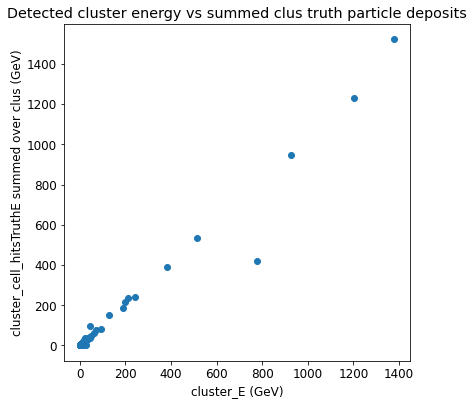

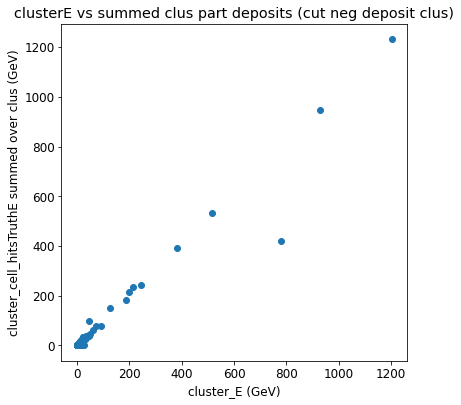

clusters with neg energy deposit: 0.9925925925925926


In [262]:
# check if the total cluster energy still approx aligns
clus_energy_from_clusterE = np.array(flatten_one_layer(events_arr["cluster_E"]))
sum_clus_energy_from_particle_deposits = np.array([np.sum(clus_contr, axis=None) for event_contr in events_arr["cluster_cell_hitsTruthE"] for clus_contr in event_contr])/1000

fig = plt.figure(figsize=(6.2,6.2))
fig.patch.set_facecolor('white')
plt.scatter(clus_energy_from_clusterE, sum_clus_energy_from_particle_deposits)
plt.title("Detected cluster energy vs summed clus truth particle deposits")
plt.xlabel("cluster_E (GeV)")
plt.ylabel("cluster_cell_hitsTruthE summed over clus (GeV)")
plt.show()

part_energy_deposits_clus = np.array([np.count_nonzero([cell_part_deposit < 0 for cell_part_deposit in flatten_layers(clus_part_deposits, 1)]) > 0 for event_part_deposits in events_arr["cluster_cell_hitsTruthE"] for clus_part_deposits in event_part_deposits])

fig = plt.figure(figsize=(6.2,6.2))
fig.patch.set_facecolor('white')
plt.scatter(clus_energy_from_clusterE[part_energy_deposits_clus != 1], sum_clus_energy_from_particle_deposits[part_energy_deposits_clus != 1])
plt.title("clusterE vs summed clus part deposits (cut neg deposit clus)")
plt.xlabel("cluster_E (GeV)")
plt.ylabel("cluster_cell_hitsTruthE summed over clus (GeV)")
plt.show()

print("clusters with neg energy deposit:", np.count_nonzero([part_energy_deposits_clus != 1]) / len(part_energy_deposits_clus))



In [240]:
# filter out cells with no recorded energy deposits
clus_cell_energies = flatten_layers(ak.Array(events_arr["cluster_cell_E"])[ak.Array(events_arr["cluster_cell_hitsE_EM"] + events_arr["cluster_cell_hitsE_nonEM"]) != 0], 1) # measured
clus_cell_energy_deposits_summed_over_part = np.array([[np.sum(part_cells_energy_deposits) for part_cells_energy_deposits in part_clus_energy_deposits] for part_event_energy_deposits in events_arr["cluster_cell_hitsTruthE"] for part_clus_energy_deposits in part_event_energy_deposits])
clus_num_part_in_cell_energy_deposits = np.array([[len(part_cells_energy_deposits) for part_cells_energy_deposits in part_clus_energy_deposits] for part_event_energy_deposits in events_arr["cluster_cell_hitsTruthE"] for part_clus_energy_deposits in part_event_energy_deposits])

clus_cell_energy_deposits_summed_over_part = [ak.Array(clus_cell_energy_deposits_summed_over_part[clus_idx])[ak.Array(num_part_in_cell_energy_deposits) != 0] for clus_idx, num_part_in_cell_energy_deposits in enumerate(clus_num_part_in_cell_energy_deposits)]

print(len(clus_cell_energies))
print(len(clus_cell_energy_deposits_summed_over_part)) # still havent cut out enough

# find the counts of cells in the clus from truth vs measured
num_cells_in_clus_measured = np.array([len(cell_energies) for cell_energies in clus_cell_energies])
num_cells_in_clus_truth_par_depo = np.array([len(cell_energy_deposits_summed_over_part) for cell_energy_deposits_summed_over_part in clus_cell_energy_deposits_summed_over_part])

misaligned_num_cells = (num_cells_in_clus_measured != num_cells_in_clus_truth_par_depo)

print(num_cells_in_clus_measured)
print(num_cells_in_clus_truth_par_depo)

print("% clus with misaligned cell values:", str((np.count_nonzero(misaligned_num_cells) / len(num_cells_in_clus_measured))*100) + "%")

# cut out the misaligned 3% of clusters and flatten
clus_cell_energies_aligned_flat = flatten_one_layer(ak.Array(clus_cell_energies)[~misaligned_num_cells])
clus_cell_energy_deposits_summed_over_part_aligned_flat = flatten_one_layer(ak.Array(clus_cell_energy_deposits_summed_over_part)[~misaligned_num_cells])

/tmp/ipykernel_38864/1112496529.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clus_cell_energy_deposits_summed_over_part = np.array([[np.sum(part_cells_energy_deposits) for part_cells_energy_deposits in part_clus_energy_deposits] for part_event_energy_deposits in events_arr["cluster_cell_hitsTruthE"] for part_clus_energy_deposits in part_event_energy_deposits])
/tmp/ipykernel_38864/1112496529.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clus_num_part_in_cell_energy_deposits = np.array([[len(part_cells_energy_deposits) for part_cells_ener

1416
1416
[33 17 12 ... 22 15 12]
[33 17 12 ... 22 15 12]
% clus with misaligned cell values: 3.3192090395480225%


77156
77156


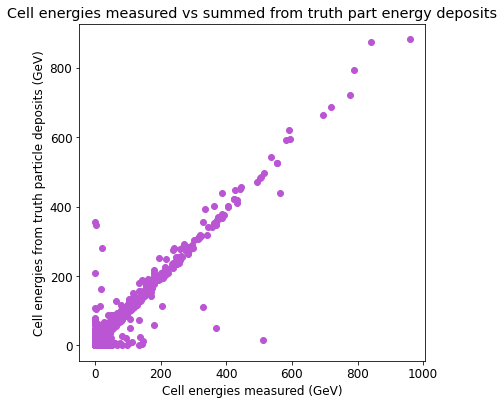

In [241]:
# print the alined num of cells energy comparison
print(len(clus_cell_energies_aligned_flat))
print(len(clus_cell_energy_deposits_summed_over_part_aligned_flat))

fig = plt.figure(figsize=(6.2,6.2))
fig.patch.set_facecolor('white')
plt.scatter(clus_cell_energies_aligned_flat, np.array(clus_cell_energy_deposits_summed_over_part_aligned_flat)/1000, color="mediumorchid")
plt.title("Cell energies measured vs summed from truth part energy deposits")
plt.xlabel("Cell energies measured (GeV)")
plt.ylabel("Cell energies from truth particle deposits (GeV)")
plt.show()

In [263]:
# Q - how to get the coordinates of the truth particle deposits????
# check if cell truth deposits by particles aligns with measured deposits
event_idx = -1
clus_idx = -1

print("nCells:", events_arr["cluster_nCells"][event_idx][clus_idx])
print("cluster_cell_hitstruthE:", len(events_arr["cluster_cell_hitsTruthE"][event_idx][clus_idx]))
print("cluster_cell_hitsE_EM:", len(events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx]))
print("cluster_cell_hitsE_EM + cluster_cell_hitsE_nonEM != 0:", np.count_nonzero(events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx] + events_arr["cluster_cell_hitsE_nonEM"][event_idx][clus_idx]))
print("num cells with particle deposit:", np.count_nonzero([len(cont_part) for cont_part in events_arr["cluster_cell_hitsTruthIndex"][event_idx][clus_idx]]))
print("num cells with all positive particle deposit:", np.count_nonzero([len(cont_part) and (np.count_nonzero(cont_part < 0) == 0) for cont_part in events_arr["cluster_cell_hitsTruthIndex"][event_idx][clus_idx]]), "\n")

for key in ['cluster_cell_ID', 'cluster_cell_E', 'cluster_cell_hitsE_EM', 'cluster_cell_hitsE_nonEM', 'cluster_cell_hitsE_Invisible', 'cluster_cell_hitsE_Escaped', 'cluster_fullHitsTruthIndex', 'cluster_fullHitsTruthE', 'cluster_visibleHitsTruthIndex', 'cluster_visibleHitsTruthE', 'cluster_cell_hitsTruthIndex', 'cluster_cell_hitsTruthE']:
    print(key + ":", len(events_arr[key][event_idx][clus_idx]))

nCells: 37
cluster_cell_hitstruthE: 37
cluster_cell_hitsE_EM: 37
cluster_cell_hitsE_EM + cluster_cell_hitsE_nonEM != 0: 37
num cells with particle deposit: 37
num cells with all positive particle deposit: 37 

cluster_cell_ID: 37
cluster_cell_E: 37
cluster_cell_hitsE_EM: 37
cluster_cell_hitsE_nonEM: 37
cluster_cell_hitsE_Invisible: 37
cluster_cell_hitsE_Escaped: 37
cluster_fullHitsTruthIndex: 2
cluster_fullHitsTruthE: 2
cluster_visibleHitsTruthIndex: 2
cluster_visibleHitsTruthE: 2
cluster_cell_hitsTruthIndex: 37
cluster_cell_hitsTruthE: 37


In [264]:
# Q - how often does it align?
print(len(events_arr["cluster_cell_E"]))
print(len(events_arr["cluster_cell_E"][0]))
print(len(events_arr["cluster_cell_E"][0][0]))
num_cells_in_clus_from_particle_deposits = np.array([np.count_nonzero([len(cont_part) and (np.count_nonzero(np.array(cont_part) < 0) == 0) for cont_part in part_deposits_clus]) for part_deposits_event in events_arr["cluster_cell_hitsTruthE"] for part_deposits_clus in part_deposits_event])
num_cells_in_clus_from_cluster_cell_E = np.array([len(cells_E[events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx] + events_arr["cluster_cell_hitsE_nonEM"][event_idx][clus_idx]]) 
    for event_idx, clus_E in enumerate(events_arr["cluster_cell_E"]) for clus_idx, cells_E in enumerate(clus_E)])

fig = plt.figure(figsize=(6.2,6.2))
fig.patch.set_facecolor('white')
plt.scatter(num_cells_in_clus_from_cluster_cell_E, num_cells_in_clus_from_particle_deposits, color="mediumorchid")
plt.title("Num cells from measured cell clus E vs num in truth particle deposits in clus")
plt.xlabel("Num cells in clus from cluster_cell_E")
plt.ylabel("Num cells in clus from cluster_cell_hitsTruthE")
plt.show()

print("same num cells:", str(round(np.count_nonzero(num_cells_in_clus_from_particle_deposits < num_cells_in_clus_from_cluster_cell_E) / len(num_cells_in_clus_from_cluster_cell_E), 3)*100) + "%")


50
4
34


ValueError: in NumpyArray attempting to get 1, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/cpu-kernels/awkward_regularize_arrayslice.cpp#L14)

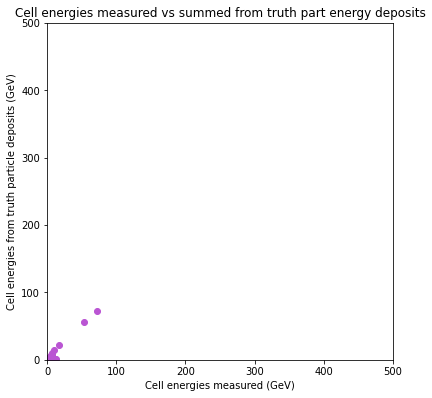

In [49]:
# filter by events with the same number of cells in both pieces of data
same_num_cells_cut = (num_cells_in_clus_from_particle_deposits == num_cells_in_clus_from_cluster_cell_E)

measured_cell_energies = flatten_one_layer(ak.Array(flatten_events_to_clus(events_arr["cluster_cell_E"]))[same_num_cells_cut])
summed_truth_part_cell_energies = np.array([np.sum(cell_part_energies) if len(cell_part_energies) else None for cell_part_energies in flatten_one_layer(ak.Array(flatten_events_to_clus(events_arr["cluster_cell_hitsTruthE"]))[same_num_cells_cut])])
summed_truth_part_cell_energies = summed_truth_part_cell_energies[summed_truth_part_cell_energies != None] / 1000

fig = plt.figure(figsize=(6.2,6.2))
fig.patch.set_facecolor('white')
plt.scatter(measured_cell_energies, summed_truth_part_cell_energies, color="mediumorchid")
plt.title("Cell energies measured vs summed from truth part energy deposits")
plt.xlabel("Cell energies measured (GeV)")
plt.ylabel("Cell energies from truth particle deposits (GeV)")
plt.xlim((0,500))
plt.ylim((0,500))
plt.show()

Negative deposits debug

In [4]:
cell_part_energy_deposits = np.array([np.sum(cell_part_energy_deposits) for cell_part_energy_deposits in flatten_layers(events_arr["cluster_cell_hitsTruthE"], 2)])
cut_neg_energy = (cell_part_energy_deposits < 0)

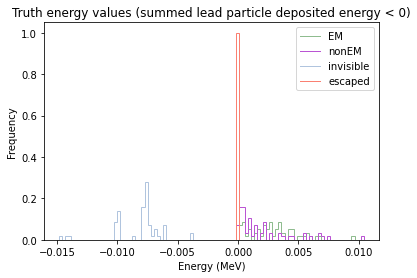

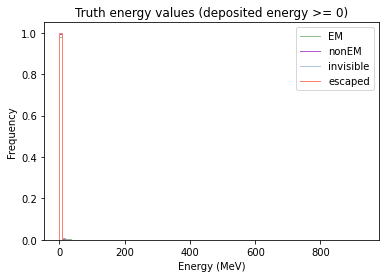

In [14]:
# plot energy distributions of the different kinds of energy depoists
cells_truth_E_EM = np.array(flatten_layers(events_arr["cluster_cell_hitsE_EM"], 2))
cells_truth_E_nonEM = np.array(flatten_layers(events_arr["cluster_cell_hitsE_nonEM"], 2))
cells_truth_E_Invisible = np.array(flatten_layers(events_arr["cluster_cell_hitsE_Invisible"], 2))
cells_truth_E_Escaped = np.array(flatten_layers(events_arr["cluster_cell_hitsE_Escaped"], 2))

pu.plot_overlay_hist([cells_truth_E_EM[cut_neg_energy], cells_truth_E_nonEM[cut_neg_energy], cells_truth_E_Invisible[cut_neg_energy], cells_truth_E_Escaped[cut_neg_energy]], 100, "Truth energy values (summed lead particle deposited energy < 0)", "Energy (MeV)", "Frequency", ["EM", "nonEM", "invisible", "escaped"], colours=["darkseagreen", "mediumorchid", "lightsteelblue", "salmon"])
pu.plot_overlay_hist([cells_truth_E_EM[~cut_neg_energy], cells_truth_E_nonEM[~cut_neg_energy], cells_truth_E_Invisible[~cut_neg_energy], cells_truth_E_Escaped[~cut_neg_energy]], 100, "Truth energy values (deposited energy >= 0)", "Energy (MeV)", "Frequency", ["EM", "nonEM", "invisible", "escaped"], colours=["darkseagreen", "mediumorchid", "lightsteelblue", "salmon"])

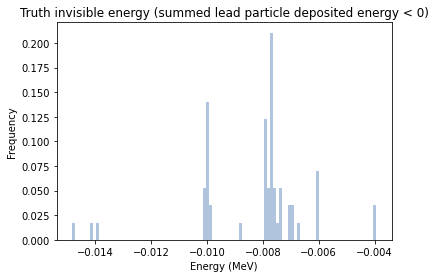

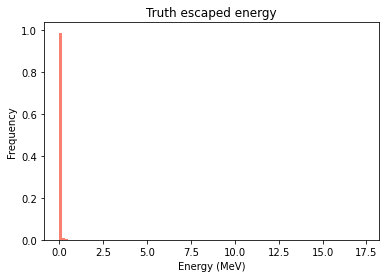

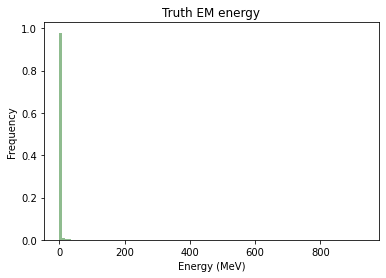

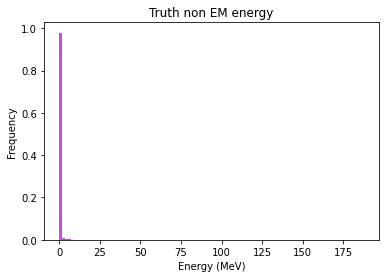

In [13]:
pu.plot_hist(cells_truth_E_Invisible[cut_neg_energy], 100, "Truth invisible energy (summed lead particle deposited energy < 0)", "Energy (MeV)", "Frequency", colour="lightsteelblue")
pu.plot_hist(cells_truth_E_Escaped, 100, "Truth escaped energy", "Energy (MeV)", "Frequency", colour="salmon")
pu.plot_hist(cells_truth_E_EM, 100, "Truth EM energy", "Energy (MeV)", "Frequency", colour="darkseagreen")
pu.plot_hist(cells_truth_E_nonEM, 100, "Truth non EM energy", "Energy (MeV)", "Frequency", colour="mediumorchid")

In [12]:
print(np.count_nonzero(cells_truth_E_Invisible < 0))
print(np.count_nonzero(cells_truth_E_Escaped < 0))
print(np.count_nonzero(cells_truth_E_nonEM < 0))
print(np.count_nonzero(cells_truth_E_EM < 0))

39297
0
0
0


Cut out cell repeats in event data

In [255]:
# flatten cell IDs and particle ID and energy deposits in cells to be lists per event
events_cells_IDs = [[cell for clus_cells in event_clus_cells for cell in clus_cells] for event_clus_cells in events_arr["cluster_cell_ID"]]
part_deposits_in_cells = [[cell for clus_cells in event_clus_cells for cell in clus_cells] for event_clus_cells in events_arr["cluster_cell_hitsTruthE"]]
part_id_in_cells = [[cell for clus_cells in event_clus_cells for cell in clus_cells] for event_clus_cells in events_arr["cluster_cell_hitsTruthIndex"]]

unique_part_deposits_in_cells = []
unique_part_id_in_cells = []

# iterate through the events and remove any repeated cell deposits (if 2+ of same cell ID in one event remove the extra)
for event_idx in np.arange(len(events_cells_IDs)):
    if len(events_cells_IDs[event_idx]):
        # get the idx of the unique cell IDs
        unique_events_cells_IDs, unique_cells_idx = np.unique(events_cells_IDs[event_idx], return_inverse=True)
        # cut the particle ID and energy depoists to just have the unique cells per event
        unique_part_deposits_in_cells.append(ak.Array(part_deposits_in_cells[event_idx])[unique_cells_idx])
        unique_part_id_in_cells.append(ak.Array(part_id_in_cells[event_idx])[unique_cells_idx])
    


In [250]:
# check
event_idx = 31
unique_events_cells_IDs_this_event, unique_cells_idx = np.unique(events_cells_IDs[event_idx], return_inverse=True)
print(len(unique_events_cells_IDs_this_event))
print(np.array(part_deposits_in_cells[event_idx])[unique_cells_idx])
print(unique_part_deposits_in_cells[event_idx])

160
[<Array [0.544] type='1 * float64'>
 <Array [0.511, 1.52, 365] type='3 * float64'>
 <Array [0.366, 1.32, 460] type='3 * float64'>
 <Array [0.345, 1.78, 240] type='3 * float64'>
 <Array [46.2] type='1 * float64'> <Array [1.48, 94.9] type='2 * float64'>
 <Array [1.11, 75.9] type='2 * float64'> <Array [470] type='1 * float64'>
 <Array [40.7] type='1 * float64'> <Array [6.56, 8.78] type='2 * float64'>
 <Array [24, 216, 282] type='3 * float64'>
 <Array [5.36, 178] type='2 * float64'>
 <Array [2.81, 105, 179] type='3 * float64'>
 <Array [0.226, 49.2, 110] type='3 * float64'>
 <Array [0.473, 2.67, 5.95] type='3 * float64'>
 <Array [3.21, 11.6] type='2 * float64'>
 <Array [0.197, 12.9, 26.3] type='3 * float64'>
 <Array [4.3, 21.7] type='2 * float64'>
 <Array [1.37, 4.73, 43.5] type='3 * float64'>
 <Array [0.511, 122] type='2 * float64'>
 <Array [0.329, 122] type='2 * float64'>
 <Array [39.3, 51.6, 276] type='3 * float64'>
 <Array [3.16, 879] type='2 * float64'>
 <Array [1.2, 1.63, 71] type

/tmp/ipykernel_27678/2397303608.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(part_deposits_in_cells[event_idx])[unique_cells_idx])


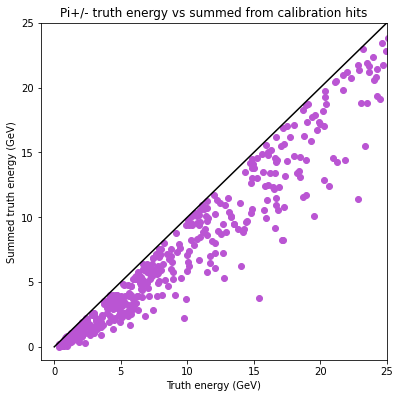

frac where full truth energy > summed: 0
frac where full truth energy > summed: 0.0


In [11]:

#pipm_particles_truth_energy = np.array(ak.Array(events_arr["truthPartE"])[:,1][events_arr["nCluster"] > 0]) # index 1 is the pi+/- particles (cut for events w > 0 clus)
#pipm_particles_deposited_energy = ak.Array(unique_part_deposits_in_cells)[ak.Array(unique_part_id_in_cells) == 1] # cut particle with index of 1 & keep shape
#pipm_summed_particles_deposited_energy = np.array([np.sum(event_pipm_particles_deposited_energy) for event_pipm_particles_deposited_energy in pipm_particles_deposited_energy])/1000 # sum for each particle over the event
#part_energy_deposits_events = np.array([np.count_nonzero([cell_part_deposit < 0 for cell_part_deposit in flatten_layers(event_part_deposits, 2)]) > 0 for event_part_deposits in events_arr["cluster_cell_hitsTruthE"]])

part_energy_deposits_events = np.array([np.count_nonzero([cell_part_deposit < 0 for cell_part_deposit in flatten_layers(event_part_deposits, 2)]) > 0 for event_part_deposits in events_arr["cluster_cell_hitsTruthE"]])
cut = (part_energy_deposits_events >= 0)


pipm_particles_truth_energy = np.array(ak.Array(events_arr["truthPartE"])[:,1])#, np.array(ak.Array(events_arr["truthPartE"])[:,3]), np.array(ak.Array(events_arr["truthPartE"])[:,4])))
pipm_summed_particles_deposited_energy = np.array(ak.Array(events_arr_summed_truth_E["truthPartE"])[:,1])#, np.array(ak.Array(events_arr_summed_truth_E["truthPartE"])[:,3]), np.array(ak.Array(events_arr_summed_truth_E["truthPartE"])[:,4])))


fig = plt.figure(figsize=(6.2,6.2))
fig.patch.set_facecolor('white')
plt.scatter(pipm_particles_truth_energy, pipm_summed_particles_deposited_energy, color="mediumorchid")
plt.title("Pi+/- truth energy vs summed from calibration hits")
plt.xlabel("Truth energy (GeV)")
plt.ylabel("Summed truth energy (GeV)")
plt.plot(np.arange(np.max(pipm_particles_truth_energy)), np.arange(np.max(pipm_particles_truth_energy)), color="black")
plt.xlim((-1, 25))
plt.ylim((-1, 25))
plt.show()


print("frac where full truth energy > summed:", np.count_nonzero(pipm_particles_truth_energy < pipm_summed_particles_deposited_energy))
print("frac where full truth energy > summed:", np.count_nonzero(pipm_particles_truth_energy < pipm_summed_particles_deposited_energy)/len(pipm_summed_particles_deposited_energy))


In [298]:
event_idx = 99
print("truthPartE:", events_arr["truthPartE"][event_idx][3])
print("summedTruthPartE:", events_arr_summed_truth_E["truthPartE"][event_idx][3])

print("truthPartE (processed):", pipm_particles_truth_energy[event_idx])
print("summedTruthPartE (processed):", pipm_summed_particles_deposited_energy[event_idx])

print(pipm_summed_particles_deposited_energy[event_idx] > pipm_particles_truth_energy[event_idx])

truthPartE: 0.06051406264305115
summedTruthPartE: 0.06053207442164421
truthPartE (processed): 0.060514063
summedTruthPartE (processed): 0.060532074
True


In [ ]:
# if the events don't align -> sort both lists by order of eventIDX
sorted_pipm_particles_truth_energy = [pipm_particles_truth_energy_event_i for _, pipm_particles_truth_energy_event_i in sorted(zip(pipm_particles_truth_energy, events_arr["eventNumber"]), key=lambda pair: pair[0])]
sorted_pipm_summed_particles_deposited_energy = [pipm_summed_particles_deposited_energy_event_i for _, pipm_summed_particles_deposited_energy_event_i in sorted(zip(pipm_summed_particles_deposited_energy, events_arr_summed_truth_E["eventNumber"]), key=lambda pair: pair[0])]